#### Part 2 - RNN

In [2]:
# data / visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# nlp libraries
import re
import string
from string import punctuation
import nltk
from nltk.corpus import stopwords   # to get collection of stopwords
nltk.download('stopwords') # download stopwords

# ml libraries
import tensorflow as tf
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer  # to encode text to int
from tensorflow.keras.preprocessing import sequence
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Embedding
from tensorflow.keras.callbacks import ModelCheckpoint   # save model
from tensorflow.keras.models import load_model   # load saved model

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Gumo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [33]:
######### Functions #########

# Regex Remove functions
# remove url
def remove_url(txt):
    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())
#remove hashtag #
def remove_hashtag(txt):
    return " ".join(re.sub("([#＃]+)([0-9A-Z_]*[A-Z_]+[a-z0-9_üÀ-ÖØ-öø-ÿ]*)", "", txt).split())
# remove mention @
def remove_at(txt):
    return " ".join(re.sub("(\@[a-zA-Z0-9_%]*)", "", txt).split())

    # remove stopwords and puncturations
def get_text_processing(text):
    stpword = stopwords.words('english')
    stpword.remove('not')
    no_punctuation = [char for char in text if char not in string.punctuation]
    no_punctuation = ''.join(no_punctuation)
    return ' '.join([word for word in no_punctuation.split() if word.lower() not in stpword])

# remove url, hashtag, at, stop words, punctuation
def removeFunc(a):
    x = remove_at(a)
    x = remove_hashtag(x)
    x = remove_url(x)
    x = get_text_processing(x.lower())
    return x

# Max length of review
def get_max_length(x):
    review_length = []
    for review in x:
        review_length.append(len(review))

    return int(np.ceil(np.mean(review_length)))


['what', 'is', 'this']

In [3]:
# load df1
df1 = pd.read_csv('data3/Twitter_Data.csv')
df1.head(1)

,clean_text,category
0,when modi promised “minimum government maximum...,-1.0


In [4]:
# load df2
df2 = pd.read_csv('data3/apple-twitter-sentiment-texts.csv')
# rename columns
df2 = df2.rename(columns={'text': 'clean_text', 'sentiment':'category'})
# change values
df2['category'] = df2['category'].map({-1: -1.0, 0: 0.0, 1:1.0})
df2.head(1)

,clean_text,category
0,Wow. Yall needa step it up @Apple RT @heynyla:...,-1.0


In [7]:
# load df3
df3 = pd.read_csv('data3/finalSentimentdata2.csv')
# rename columns
df3 = df3.rename(columns={'text': 'clean_text', 'sentiment':'category'})
# change values
df3['category'] = df3['category'].map({'sad': -1.0, 'anger': -1.0, 'fear': -1.0, 'joy':1.0})

# change column order
df3 = df3[['clean_text','category']]
df3.head(1)

,clean_text,category
0,agree the poor in india are treated badly thei...,-1.0


In [8]:
# load df4
df4 = pd.read_csv('data3/Tweets.csv')
# rename columns
df4 = df4.rename(columns={'text': 'clean_text', 'airline_sentiment':'category'})
# change values
df4['category'] = df4['category'].map({'negative': -1.0, 'neutral': 0.0, 'positive':1.0})
# change column order
df4 = df4[['clean_text','category']]
df4.head(1)

,clean_text,category
0,@VirginAmerica What @dhepburn said.,0.0


In [10]:
# merge all df into 1 
df = pd.concat([df1, df2, df3, df4], ignore_index=True)
df.shape

(182340, 2)

In [11]:
df.isnull().sum()

clean_text    4
category      7
dtype: int64

In [14]:
# drop na and initialize cleandf
cleandf = df.dropna(axis=0)
cleandf.shape

(182329, 2)

In [15]:
cleandf.category.unique()

array([-1.,  0.,  1.])

In [16]:
# rename columns
cleandf = cleandf.rename(columns={'category': 'score'})
cleandf.head(1)

,clean_text,score
0,when modi promised “minimum government maximum...,-1.0


In [17]:
# create category column
cleandf['category'] = cleandf['score'].map({-1.0:'Negative', 0.0:'Neutral', 1.0:'Positive'})

cleandf.head(1)

,clean_text,score,category
0,when modi promised “minimum government maximum...,-1.0,Negative


Text(0.5, 1.0, 'Sentiment Count')

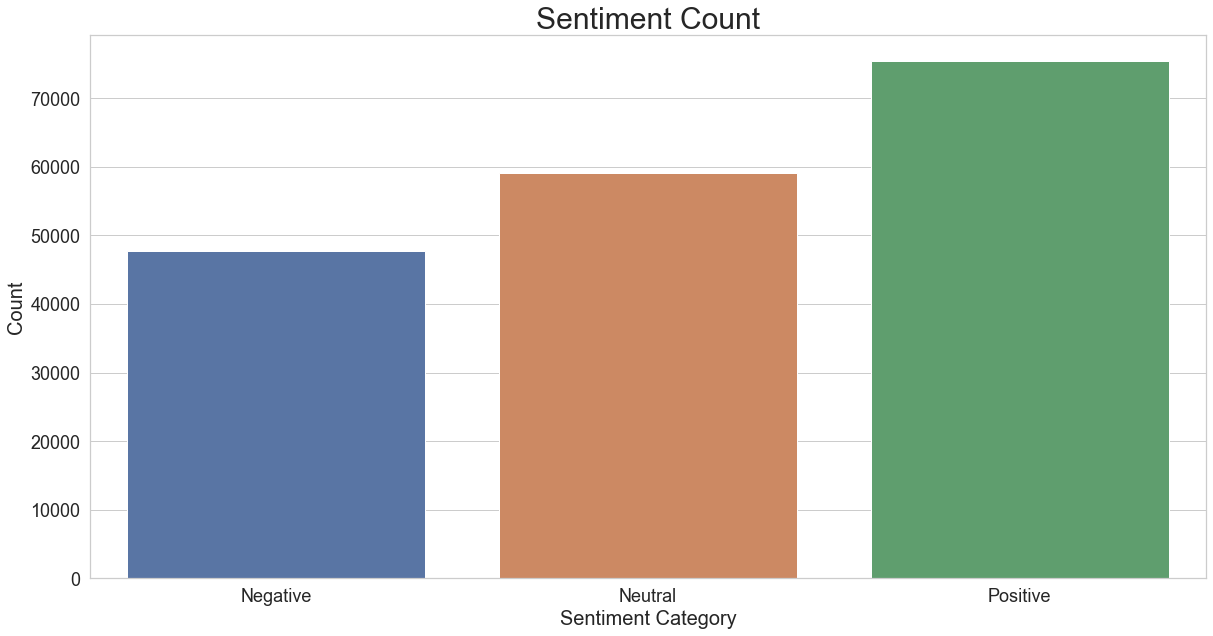

In [21]:
plt.figure(figsize=(20,10))
# set theme
sns.set_theme(style="whitegrid")
#countplot ploarity
sns.countplot(x=cleandf.category)



plt.xlabel('Sentiment Category', fontsize=20)
plt.ylabel('Count', fontsize = 20)
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.title('Sentiment Count', fontsize=30)

In [27]:
processdf = cleandf
# filter text
processdf['filter_text'] = processdf.clean_text.apply(removeFunc)
processdf.head(1)

In [30]:
#split filtered text
processdf['split_filter_text'] = processdf.filter_text.apply(lambda x: x.split())
processdf.head(1)

,clean_text,score,category,filter_text,split_filter_text
0,when modi promised “minimum government maximum...,-1.0,Negative,modi promised minimum government maximum gover...,"[modi, promised, minimum, government, maximum,..."


In [31]:
# dldf - deep learning data frame
dldf = processdf
x_data = dldf.split_filter_text
y_data = dldf.score
print(x_data[3])
print(y_data[3])

['asking', 'supporters', 'prefix', 'chowkidar', 'names', 'modi', 'great', 'service', 'confusion', 'read', 'not', 'crustal', 'clear', 'crass', 'filthy', 'nonsensical', 'see', 'abuses', 'coming', 'chowkidars']
1.0


In [34]:
# train test split
X_train, X_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

In [ ]:
max_length = get_max_length(X)
print(max_length)